# Data Preparation

## Import Packages

In [342]:
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import style
style.use('dark_background')
import statsmodels.api as sm
import os
import random

## Change Working Directory

In [343]:
os.chdir('/Users/Ryzen/Documents/04. Side Project/06. Project Lab Susenas')

## Functions for Data Preparation

### Check Missing Value

In [344]:
def missing_value(df):
    """
    Function to calculate percentage of missing values per column for a given dataframe
    
    input:
        df : given dataframe
        
    output:
        a table of columns of percentage of missing value in a dataframe per column
    """
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

### Drop Missing Value

In [345]:
def drop_missingval(df, col_names):
    """
    Function to drop missing value of a given column
    
    input:
        df      (str)    : given dataframe
        col_names (list) : name of column(s) to be treated in the form of a list
        
    output:
        recap of missing value of the given dataframe after treatment
    """
    
    if len(col_names) > 1:
        for i in col_names:
            df.dropna(subset=[i], inplace=True)
    else:
        df.dropna(subset=col_names, inplace=True)
    
    return missing_value(df)

### Drop Columns

In [346]:
def drop_col(df, col_names):
    """
    Function to drop column(s)
    
    input:
        df      (str)    : given dataframe
        col_names (list) : name of column(s) to be dropped
        
    output:
        final datafrae
    """
    
    df.drop(columns=col_names, axis=1)
    
    return df

## Import Data

### 2012

In [347]:
# Kor
sus12_ki = pd.read_csv('data/susenas12/sn12_ki.csv')
sus12_kr = pd.read_csv('data/susenas12/sn12_krt.csv')

# Modul
sus12_m41_p1 = pd.read_csv('data/susenas12/sn12_m41p1.csv')
sus12_m41_p2 = pd.read_csv('data/susenas12/sn12_m41p2.csv')
sus12_m42 = pd.read_csv('data/susenas12/sn12_m42.csv')
sus12_m43 = pd.read_csv('data/susenas12/sn12_m43.csv')

### 2013

In [348]:
# Kor
sus13_ki = pd.read_csv('data/susenas13/sn13_ki.csv')
sus13_kr = pd.read_csv('data/susenas13/sn13_krt.csv')
sus13_kr_poor = pd.read_csv('data/susenas13/sn13_krt_poor.csv')

# Modul
sus13_m41 = pd.read_csv('data/susenas13/sn13_m41.csv')
sus13_m42 = pd.read_csv('data/susenas13/sn13_m42.csv')
sus13_m43 = pd.read_csv('data/susenas13/sn13_m43.csv')

## Data Exploration

### Comparing 2012 vs 2013

Even though we have 2 years of Susenas data, we will only use data from 2012 as observation, because:
- Data from 2012 is already consolidated based on survey from March, June, September, and December, which means we have data from around 1,1M people and around 286K households.
- Data from 2013 is only from survey from March, hence we only have data from 274K people and around 69K households.

Data from 2013 is only representative if we aggregate it at max on province level. This will be an issue if we want to perform simple regression, because if we use province level data, we would only have  __n=68__ (2 years of data multiplied by 34 provinces).

Hence, for Exploratory Data Analysis, we will treat the dataset from each year differently:
- Data Susenas Kor 2012, on individual level
- Data Susenas Kor 2012, on kabupaten/kota level (*groupby* kabupaten/kota)

In [349]:
# Creating Count Statistics for Our Datasets
sus12_kr_desc = sus12_kr['URUT'].agg(['count','nunique']).transpose()
sus12_ki_desc = sus12_ki['URUT'].agg(['count','nunique']).transpose()
sus13_kr_desc = sus13_kr['urut'].agg(['count','nunique']).transpose()
sus13_ki_desc = sus13_ki['urut'].agg(['count','nunique']).transpose()

plot_describe = pd.concat([sus12_ki_desc,sus12_kr_desc,sus13_ki_desc,sus13_kr_desc],axis=1)
plot_describe.columns=['2012 Individuals','2012 Households','2013 Individuals','2013 Households']
lst = list(plot_describe.columns)
for c in lst:
    plot_describe[c] = plot_describe[c].astype(int).apply(lambda x: f'{x:,}')
    
plot_describe

,2012 Individuals,2012 Households,2013 Individuals,2013 Households
count,"1,114,445","286,113","274,051","70,842"
nunique,"286,113","286,113","69,514","69,514"


### Choosing Relevant Variables

1. __B1R8__: Nomor urut sampel rumah tangga
2. __b1r1__: Kode Provinsi 
3. __b1r2__: Kode Kabupaten
4. __KABU__: Kab/Kota
5. __b1r5__: Klasifikasi desa/kelurahan (apakah berstatus daerah perkotaan/pedesaan)
6. __B5_TL1__: Tempat lahir (provinsi/negara)
7. __B5_TL2__: Tempat lahir (kabupaten/kota)
8. __B5_TT1__: Tempat tinggal (provinsi/negara)
9. __B5_TT2__: Tempat tinggal (kabupaten/kota)
10. __b4r5/umur__: Umur/usia responden
11. __JK__: Jenis Kelamin
12. __KWN__: Status perkawinan
13. __b5r17__: Ijazah/STTB tertinggi yang dimiliki
14. __B5R27A__: Apakah bekerja dalam 3 bulan terakhir
15. __B5R27B__: Sarana angkutan yang biasa digunakan untuk bekerja
16. __B5R28A__: Jumlah hari kerja
17. __B5R28B__: Jumlah jam kerja
18. __B5R29__: Berapa pendapatan bersih pekerjaan utama sebulan
19. __B5R30__: Lapangan usaha/bidang pekerjaan utama?
20. __B5R31__: Status/kedudukan dlm pekerjaan utama?
21. __exp_cap__: Pengeluaran per kapita

In [350]:
# Subsetting Dataset to Selected Variables
df_raw = sus12_ki[['URUT',
                   'B1R8',
                   'B1R1',
                   'B1R2',
                   'KABU',
                   'B1R5',
                   'B5_TL1',
                   'B5_TL2',
                   'B5_TT1',
                   'B5_TT2',
                   'UMUR',
                   'JK',
                   'KWN',
                   'B5R17',
                   'B5R27A',
                   'B5R27B',
                   'B5R28A',
                   'B5R28B',
                   'B5R29',
                   'B5R30',
                   'B5R31',
                   'EXP_CAP',
                   'WEIND']]

As we might check whether the fact that an individual moved from their place of birth has any impact, below, we will create _place_of_birth_ and _place_of_res_ identifier.

In [351]:
# Creating District Identifier
df_raw=df_raw.assign(bps_2009=df_raw['B1R1']*100+df_raw['B1R2'])

# Creating Place of Birth Identifier
df_raw=df_raw.assign(place_of_birth=df_raw['B5_TL1']*100+df_raw['B5_TL2'])

# Creating Place of Residence Identifier
df_raw=df_raw.assign(place_of_res=df_raw['B5_TT1']*100+df_raw['B5_TT2'])

df_raw

,URUT,B1R8,B1R1,B1R2,KABU,B1R5,B5_TL1,B5_TL2,B5_TT1,B5_TT2,UMUR,JK,KWN,B5R17,B5R27A,B5R27B,B5R28A,B5R28B,B5R29,B5R30,B5R31,EXP_CAP,WEIND,bps_2009,place_of_birth,place_of_res
0,110112500101601,1,11,1,1101,1,11,1,11,1,41,1,2,8.0,1.0,3.0,7.0,35.0,0.0,8.0,2.0,3.434643e+05,45.876255,1101,1101,1101
1,110112500101601,1,11,1,1101,1,11,1,11,1,30,2,2,8.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.434643e+05,45.876255,1101,1101,1101
2,110112500101601,1,11,1,1101,1,11,1,11,1,5,2,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.434643e+05,45.876255,1101,1101,1101
3,110112500101601,1,11,1,1101,1,11,1,0,0,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.434643e+05,45.876255,1101,1101,0
4,110112500101602,2,11,1,1101,1,11,1,11,1,35,1,2,5.0,1.0,3.0,7.0,56.0,0.0,11.0,3.0,5.703095e+05,55.252186,1101,1101,1101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114440,947122001103810,10,94,71,9471,2,94,71,94,71,37,2,2,8.0,1.0,6.0,5.0,10.0,500000.0,16.0,4.0,1.348310e+06,6.000000,9471,9471,9471
1114441,947122001103810,10,94,71,9471,2,94,71,94,71,10,1,1,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.348310e+06,6.000000,9471,9471,9471
1114442,947122001103810,10,94,71,9471,2,94,71,94,71,9,2,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.348310e+06,6.000000,9471,9471,9471
1114443,947122001103810,10,94,71,9471,2,94,71,94,71,46,2,1,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.348310e+06,6.000000,9471,9471,9471


### Checking Missing Value

In [352]:
missing_value(df_raw)

,Total,Percent
B5R29,628776,56.420550
B5R28B,594543,53.348797
B5R28A,594543,53.348797
B5R31,590171,52.956494
B5R30,590171,52.956494
B5R27B,583586,52.365617
B5R27A,221507,19.875992
B5R17,190644,17.106632
B5_TL1,0,0.000000
B1R5,0,0.000000


In [353]:
df_raw.describe()

,URUT,B1R8,B1R1,B1R2,KABU,B1R5,B5_TL1,B5_TL2,B5_TT1,B5_TT2,UMUR,JK,KWN,B5R17,B5R27A,B5R27B,B5R28A,B5R28B,B5R29,B5R30,B5R31,EXP_CAP,WEIND,bps_2009,place_of_birth,place_of_res
count,1.114445e+06,1.114445e+06,1.114445e+06,1.114445e+06,1.114445e+06,1.114445e+06,1.114445e+06,1.114445e+06,1.114445e+06,1.114445e+06,1.114445e+06,1.114445e+06,1.114445e+06,923801.000000,892938.000000,530859.000000,519902.000000,519902.000000,4.856690e+05,524274.000000,524274.000000,1.114445e+06,1.114445e+06,1.114445e+06,1.114445e+06,1.114445e+06
mean,4.250205e+14,5.453136e+00,4.228051e+01,2.197639e+01,4.250027e+03,1.571149e+00,4.175780e+01,2.105722e+01,3.820608e+01,2.013679e+01,2.924639e+01,1.498904e+00,1.642251e+00,4.203683,1.405492,2.340819,5.699216,38.761794,6.288832e+05,8.145720,3.482755,6.414489e+05,2.199646e+02,4.250027e+03,4.196837e+03,3.840745e+03
std,2.471679e+14,2.857661e+00,2.474286e+01,2.653410e+01,2.471674e+03,4.949122e-01,2.422245e+01,2.573990e+01,2.641843e+01,2.621360e+01,1.997500e+01,4.999990e-01,7.380006e-01,3.705277,0.490987,2.041987,1.538283,18.224239,1.466589e+06,5.882204,1.749210,7.558085e+05,2.081108e+02,2.471674e+03,2.420014e+03,2.642632e+03
min,1.101125e+14,1.000000e+00,1.100000e+01,1.000000e+00,1.101000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000,6.707492e+04,1.000000e+00,1.101000e+03,1.000000e+02,0.000000e+00
25%,1.805125e+14,3.000000e+00,1.800000e+01,4.000000e+00,1.805000e+03,1.000000e+00,1.800000e+01,4.000000e+00,1.500000e+01,3.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,5.000000,27.000000,0.000000e+00,3.000000,2.000000,3.033944e+05,8.018752e+01,1.805000e+03,1.807000e+03,1.503000e+03
50%,3.507220e+14,5.000000e+00,3.500000e+01,9.000000e+00,3.507000e+03,2.000000e+00,3.500000e+01,9.000000e+00,3.300000e+01,8.000000e+00,2.700000e+01,1.000000e+00,2.000000e+00,2.000000,1.000000,1.000000,6.000000,40.000000,0.000000e+00,8.000000,4.000000,4.572752e+05,1.457933e+02,3.507000e+03,3.504000e+03,3.325000e+03
75%,6.311220e+14,8.000000e+00,6.300000e+01,2.400000e+01,6.311000e+03,2.000000e+00,6.300000e+01,2.200000e+01,6.200000e+01,2.100000e+01,4.400000e+01,2.000000e+00,2.000000e+00,8.000000,2.000000,3.000000,7.000000,49.000000,8.000000e+05,11.000000,5.000000,7.398477e+05,2.941666e+02,6.311000e+03,6.304000e+03,6.208000e+03
max,9.471220e+14,1.000000e+01,9.400000e+01,7.900000e+01,9.471000e+03,2.000000e+00,9.400000e+01,7.900000e+01,9.400000e+01,7.900000e+01,9.800000e+01,2.000000e+00,4.000000e+00,15.000000,2.000000,10.000000,7.000000,98.000000,1.000000e+08,19.000000,6.000000,7.529981e+07,4.941000e+03,9.471000e+03,9.471000e+03,9.471000e+03


In [354]:
null_income = ((df_raw['B5R29'] == 0).sum()/df_raw['URUT'].count())*100
notnull_income = ((df_raw['B5R29'] > 0).sum()/df_raw['URUT'].count())*100

print(f'{null_income:.2f}% of Nett Income column has value of 0, and only {notnull_income:.2f}% of nett income column has value more than 0.')

28.47% of Nett Income column has value of 0, and only 15.11% of nett income column has value more than 0.


_B5R29_ or nett income data has 56.42% missing value. Additionally, 28.47% of Nett Income column has value of 0, and only 15.11% of nett income column has value more than 0. As data imputation might skew the analysis results, we have two (2) options:
1. Only use 15% of data that is not null; OR
2. Use _EXP_CAP_ or average monthly expenditure per capita as an inference of income

We will create two (2) dataframes to test both options. However, since most of the treatment is similar, we will treat the dataframe first before splitting it into two. Treatment are listed below:
1. Slice Dataset to 25-64 demographics, since the focus of the analysis only applies those whose working professionaly.
2. xxx

Specifically for each dataset, the treatment below will be applied:
1. For _df_income_ which is using Nett Income, we will drop both missing value and value of 0 from nett income field, and will only be working with 15.11% of remaining data.
2. For _df_cap_ which is using average monthly expenditure per capita as an inference of income, we will...

In [355]:
df_treat = df_raw.copy()

#### Slice Dataset to 25-64 demographics

Since the focus of the analysis only applies those whose working professionaly, we can filter the age of individuals.

In [356]:
# Slice Dataset to 25-68 Demographics
#df_treat = df_treat.loc[(df_treat['UMUR']>=25)&(df_treat['UMUR']<69)]

#### Create years of school field

_B5R17_ will be used to create a new field _yrs_school_ or years of schooling, where the level of last education is translated of number of cumulative years of schooling.

In [357]:
certif = [(df_treat['B5R17']==np.nan),(df_treat['B5R17']==1), (df_treat['B5R17']==2), (df_treat['B5R17']==3),
          (df_treat['B5R17']==4), (df_treat['B5R17']==5), (df_treat['B5R17']==6),
          (df_treat['B5R17']==7), (df_treat['B5R17']==8), (df_treat['B5R17']==9),
          (df_treat['B5R17']==10), (df_treat['B5R17']==11), (df_treat['B5R17']==12),
          (df_treat['B5R17']==13), (df_treat['B5R17']==14), (df_treat['B5R17']==15)]

yofs = [0,3,6,6,6,9,9,9,12,12,12,12,14,15,16,18]

df_treat['yrs_school']=np.select(certif,yofs)

#### Create gender field

In [358]:
df_treat['JK'].value_counts()

1    558444
2    556001
Name: JK, dtype: int64

We will just change the field input of _JK_ where _1_ is _1_ or _Male_ and _2_ is _0_ or _Female_.

In [359]:
df_treat.loc[df_treat['JK']==1,'gender']=1
df_treat.loc[df_treat['JK']==2,'gender']=0

#### Create Urban Status Variable

B1R5 wil be changed to a boolean field, where _1_ is _True_ and _2_ is _False_.

In [360]:
df_treat.loc[df_treat['B1R5']==1,'urban']=1
df_treat.loc[df_treat['B1R5']==2,'urban']=0

#### Create Location Status Variable

A new boolean field named _moved_  will be created, where if the place of birth is the same with place of residence then the value is _False_ but if it's different, then the value is _True_.

In [361]:
# Create Location Status Variable
df_treat.loc[df_treat['place_of_birth']==df_treat['place_of_res'],'moved']=0
df_treat.loc[df_treat['place_of_birth']!=df_treat['place_of_res'],'moved']=1

#### Create is_working Status Variable

_B5R27A_ wil be changed to a boolean field, where _1_ is _True_ and _2_ is _False_.

In [362]:
df_treat.loc[df_treat['B5R27A']==1,'is_working']=1
df_treat.loc[df_treat['B5R27A']==2,'is_working']=0

#### Create commute vehicle Variable

_B5R27B_ or type of commute vehicle has 10 possible answers. We will simplify this into only 5:
- _0_ is no commute vehicle
- _1_ is using public transpot
- _2_ is using own vehicle
- _3_ is using staff vehicle (kendaraan dinas)
- _4_ is others

In [363]:
# Create commute vehicle variable
df_treat.loc[df_treat['B5R27B']==1,'commute_vehicle']=0
df_treat.loc[df_treat['B5R27B']==2,'commute_vehicle']=2
df_treat.loc[df_treat['B5R27B']==3,'commute_vehicle']=2
df_treat.loc[df_treat['B5R27B']==4,'commute_vehicle']=1
df_treat.loc[df_treat['B5R27B']==5,'commute_vehicle']=1
df_treat.loc[df_treat['B5R27B']==6,'commute_vehicle']=1
df_treat.loc[df_treat['B5R27B']==7,'commute_vehicle']=2
df_treat.loc[df_treat['B5R27B']==8,'commute_vehicle']=3
df_treat.loc[df_treat['B5R27B']==9,'commute_vehicle']=3
df_treat.loc[df_treat['B5R27B']==10,'commute_vehicle']=4

#### Creating Log PCE Data

To aid with data visualizations, EXP_CAP or average monthly expenditure per capita as an inference of income will be transformed to its log format.

In [364]:
# Creating Log PCE Data
df_treat = df_treat.assign(log_exp_cap=np.log(df_treat['EXP_CAP']))

#### Rename Columns

To help with analysis, we can change the name of columns that is more easily understandable.

In [365]:
df_treat = df_treat.rename(columns = {'B5R27B' :'commute_ori',
                                      'B5R28A' : 'work_day',
                                      'B5R28B' : 'work_hour',
                                      'B5R29'  : 'nett_income',
                                      'B5R30'  : 'industry',
                                      'B5R31'  : 'employ_status',
                                      'UMUR'   : 'age',
                                      'KWN'    : 'marital_status'}, inplace = False)

#### Drop Unnecessary fields

Since treatment is done, we can now dropped unnecessary fields.

In [366]:
# Drop Unnecessary Data
df_treat = df_treat.drop(columns=['JK','B1R8','B1R5','B5R17','KABU','B1R1','B5R27A','B1R2','B5_TL1','B5_TL2','B5_TT1','B5_TT2','place_of_birth','place_of_res'],axis=1)

In [367]:
df_treat.describe()

,URUT,age,marital_status,commute_ori,work_day,work_hour,nett_income,industry,employ_status,EXP_CAP,WEIND,bps_2009,yrs_school,gender,urban,moved,is_working,commute_vehicle,log_exp_cap
count,1.114445e+06,1.114445e+06,1.114445e+06,530859.000000,519902.000000,519902.000000,4.856690e+05,524274.000000,524274.000000,1.114445e+06,1.114445e+06,1.114445e+06,1.114445e+06,1.114445e+06,1.114445e+06,1.114445e+06,892938.000000,530859.000000,1.114445e+06
mean,4.250205e+14,2.924639e+01,1.642251e+00,2.340819,5.699216,38.761794,6.288832e+05,8.145720,3.482755,6.414489e+05,2.199646e+02,4.250027e+03,6.097921e+00,5.010961e-01,4.288511e-01,2.583824e-01,0.594508,0.908025,1.310852e+01
std,2.471679e+14,1.997500e+01,7.380006e-01,2.041987,1.538283,18.224239,1.466589e+06,5.882204,1.749210,7.558085e+05,2.081108e+02,2.471674e+03,4.488437e+00,4.999990e-01,4.949122e-01,4.377455e-01,0.490987,1.092309,6.627047e-01
min,1.101125e+14,0.000000e+00,1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000,6.707492e+04,1.000000e+00,1.101000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.111357e+01
25%,1.805125e+14,1.200000e+01,1.000000e+00,1.000000,5.000000,27.000000,0.000000e+00,3.000000,2.000000,3.033944e+05,8.018752e+01,1.805000e+03,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.262279e+01
50%,3.507220e+14,2.700000e+01,2.000000e+00,1.000000,6.000000,40.000000,0.000000e+00,8.000000,4.000000,4.572752e+05,1.457933e+02,3.507000e+03,6.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000,1.303304e+01
75%,6.311220e+14,4.400000e+01,2.000000e+00,3.000000,7.000000,49.000000,8.000000e+05,11.000000,5.000000,7.398477e+05,2.941666e+02,6.311000e+03,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,2.000000,1.351420e+01
max,9.471220e+14,9.800000e+01,4.000000e+00,10.000000,7.000000,98.000000,1.000000e+08,19.000000,6.000000,7.529981e+07,4.941000e+03,9.471000e+03,1.800000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,4.000000,1.813699e+01


#### Split dataframe into _df_income_ and _df_cap_

##### _df_income_

In [368]:
df_income = df_treat.copy()

In [369]:
df_income = df_income[df_income['nett_income']> 0]

In [370]:
# Dropping null values 
drop_missingval(df_income,['nett_income'])

,Total,Percent
work_day,827,0.491005
work_hour,827,0.491005
commute_ori,234,0.138930
commute_vehicle,234,0.138930
employ_status,1,0.000594
industry,1,0.000594
log_exp_cap,0,0.000000
age,0,0.000000
marital_status,0,0.000000
nett_income,0,0.000000


As seen in the table above, even after we drop the null values from nett income field, and filter to only rows of data where nett income is greater than 0, for the following fields, there's still null values:
1. _work_hour_ or total working hours;
2. _work_day_ or total working day;
3. _commute_vehicle_ or the type vehicle used for commuting;
4. _industry_ or job sector

These null values will be dropped.

In [371]:
drop_missingval(df_income,['work_hour','work_day','commute_vehicle','commute_ori','employ_status','industry'])

,Total,Percent
log_exp_cap,0,0.0
employ_status,0,0.0
age,0,0.0
marital_status,0,0.0
commute_ori,0,0.0
work_day,0,0.0
work_hour,0,0.0
nett_income,0,0.0
industry,0,0.0
EXP_CAP,0,0.0


##### Histogram for Nett Income

Median: 1325000.0
Mean: 1813547.131705307
Std Dev: 2012217.471191731


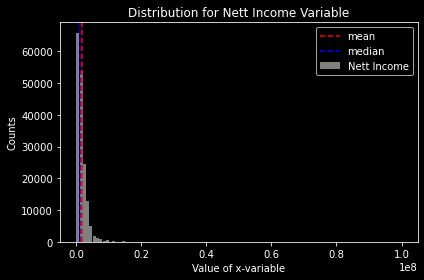

In [372]:
# Histogram for Log Expenditure per Capita Variable
plot_inc = df_income['nett_income']

plot_inc.plot.hist(grid=False, bins=99, rwidth=0.9,color='grey',label='Nett Income')
line1 = plt.axvline(plot_inc.mean(), color="r", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(plot_inc), color="b", linestyle="--", label = "median")
plt.title('Distribution for Nett Income Variable')
plt.xlabel('Value of x-variable')
plt.ylabel('Counts')
plt.legend(loc="best")
plt.tight_layout()
plt.rcParams['figure.figsize'] = [10, 4]
print("Median:", np.median(plot_inc))
print("Mean:", plot_inc.mean())
print("Std Dev:", np.std(plot_inc))
plt.show()

Nett Income seems to be skewed to the left. Additional treatment to the data might be required before we go towards modeling.

##### Histogram of Log Expenditure per Capita Variable

Median: 13.361040968956203
Mean: 13.416329151586964
Std Dev: 0.6943480025045148


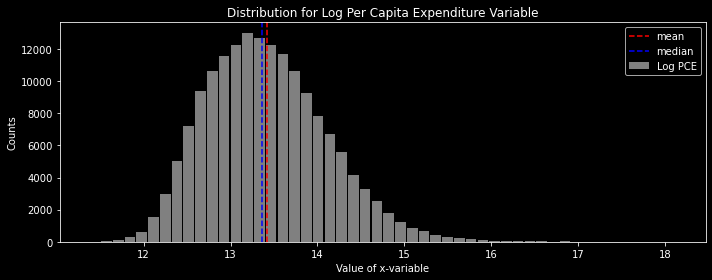

In [373]:
# Histogram for Log Expenditure per Capita Variable

plot_exp = df_income['log_exp_cap']

plot_exp.plot.hist(grid=False, bins=50, rwidth=0.9,color='grey',label='Log PCE')
line1 = plt.axvline(plot_exp.mean(), color="r", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(plot_exp), color="b", linestyle="--", label = "median")
plt.title('Distribution for Log Per Capita Expenditure Variable')
plt.xlabel('Value of x-variable')
plt.ylabel('Counts')
plt.legend(loc="best")
plt.tight_layout()
plt.rcParams['figure.figsize'] = [10, 4]
print("Median:", np.median(plot_exp))
print("Mean:", plot_exp.mean())
print("Std Dev:", np.std(plot_exp))
plt.show()

Log Expenditure per Capita Variable seems to already quiet normal. It might be more ideal to be used for modeling, as no further treatment is necessary.

##### Histogram of Age

Median: 35.0
Mean: 35.7783769902414
Std Dev: 11.474589039162716


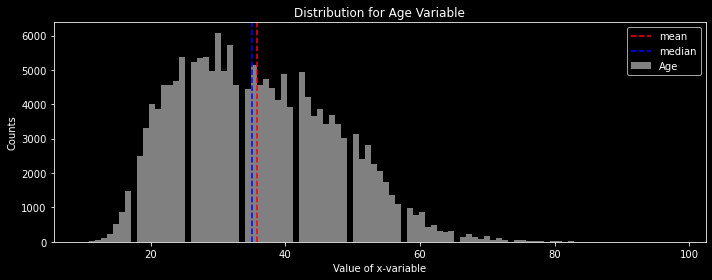

In [376]:
# Histogram for Age Variable
plot_umur = df_income['age']

plot_umur.plot.hist(grid=False, bins=99, rwidth=1,color='grey',label='Age')
line1 = plt.axvline(plot_umur.mean(), color="r", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(plot_umur), color="b", linestyle="--", label = "median")
plt.title('Distribution for Age Variable')
plt.xlabel('Value of x-variable')
plt.ylabel('Counts')
plt.legend(loc="best")
plt.tight_layout()
plt.rcParams['figure.figsize'] = [10, 4]
print("Median:", np.median(plot_umur))
print("Mean:", plot_umur.mean())
print("Std Dev:", np.std(plot_umur))
plt.show()

##### Histogram for work_hour

Median: 45.0
Mean: 43.69618136429331
Std Dev: 15.627816264328656


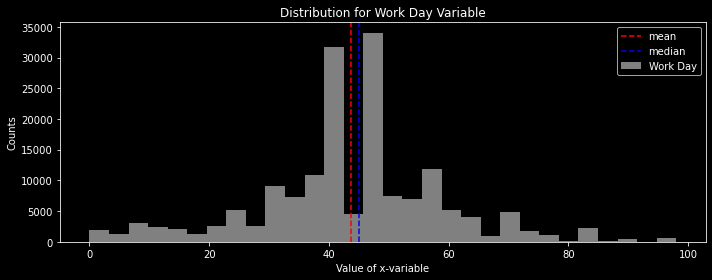

In [377]:
# Histogram for Age Variable
plot_wkhour = df_income['work_hour']

plot_wkhour.plot.hist(grid=False, bins=30, rwidth=1,color='grey',label='Work Day')
line1 = plt.axvline(plot_wkhour.mean(), color="r", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(plot_wkhour), color="b", linestyle="--", label = "median")
plt.title('Distribution for Work Day Variable')
plt.xlabel('Value of x-variable')
plt.ylabel('Counts')
plt.legend(loc="best")
plt.tight_layout()
plt.rcParams['figure.figsize'] = [10, 4]
print("Median:", np.median(plot_wkhour))
print("Mean:", plot_wkhour.mean())
print("Std Dev:", np.std(plot_wkhour))
plt.show()

##### Count plot for work_day

<AxesSubplot:ylabel='work_day'>

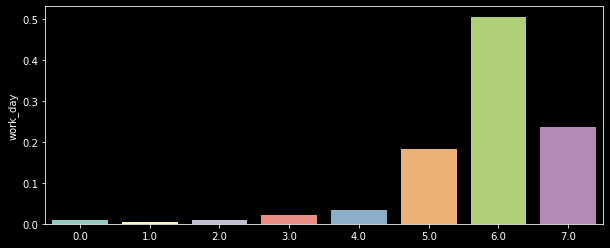

In [378]:
sns.barplot(x=df_income['work_day'].value_counts().index,
            y=df_income['work_day'].value_counts(normalize = True))

Most observations seems to work 6 days a week, followed by 7 days and 5 days a week.

##### Count Plot for Gender

<AxesSubplot:ylabel='gender'>

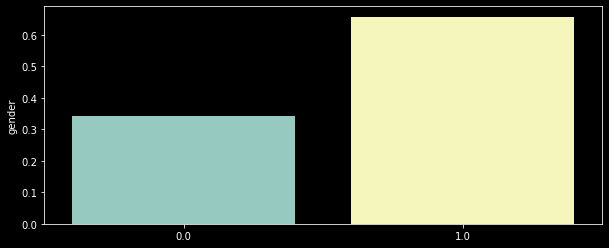

In [379]:
sns.barplot(x=df_income['gender'].value_counts().index,
            y=df_income['gender'].value_counts(normalize = True))

There are more **Male** compared to **Female** with a ratio of 2 to 1.

##### Count Plot for Years of Schooling

<AxesSubplot:ylabel='yrs_school'>

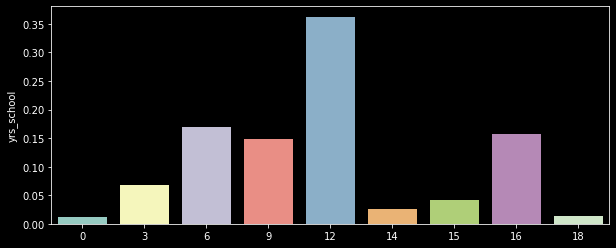

In [380]:
sns.barplot(x=df_income['yrs_school'].value_counts().index,
            y=df_income['yrs_school'].value_counts(normalize = True))

Majority of observations has the highest level of education as **High School**. 

##### Count Plot for marital_status

<AxesSubplot:ylabel='marital_status'>

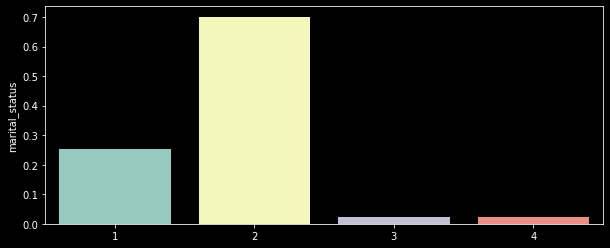

In [381]:
sns.barplot(x=df_income['marital_status'].value_counts().index,
            y=df_income['marital_status'].value_counts(normalize = True))

Most observation is **Married**, and some are still **Single**. Only a small number is either **Widowed** or **Divorced**.

##### Count Plot for urban

<AxesSubplot:ylabel='urban'>

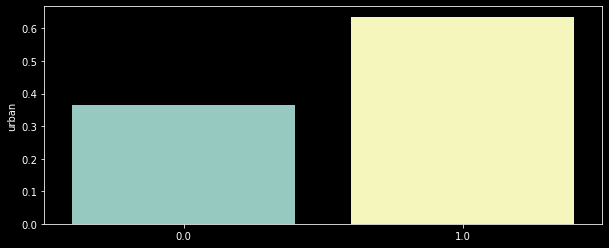

In [382]:
sns.barplot(x=df_income['urban'].value_counts().index,
            y=df_income['urban'].value_counts(normalize = True))

There are more observation that lives in an **Urban** location compared to those not living in an Urban location with a ratio of 2 to 1.

##### Count Plot for employ_status

<AxesSubplot:ylabel='employ_status'>

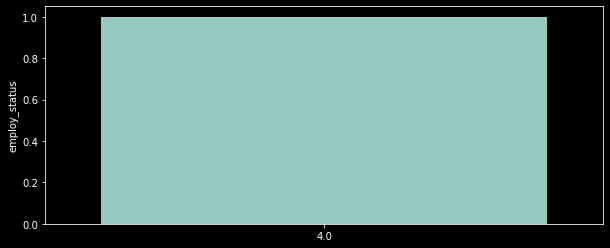

In [383]:
sns.barplot(x=df_income['employ_status'].value_counts().index,
            y=df_income['employ_status'].value_counts(normalize = True))

It seems that when we removed rows that does not have income or income is greater than 0, the only remaining rows is the on that is considered to be **Full-time/Paid Labor**

##### Count Plot for commute_vehicle

<AxesSubplot:ylabel='commute_vehicle'>

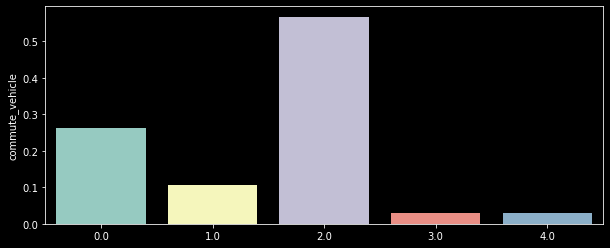

In [384]:
sns.barplot(x=df_income['commute_vehicle'].value_counts().index,
            y=df_income['commute_vehicle'].value_counts(normalize = True))

There are more observations using **Own Vehicle** to commute, followed by not using any vehicle at all and **Public Transport**.

##### Count Plot for industry

<AxesSubplot:ylabel='industry'>

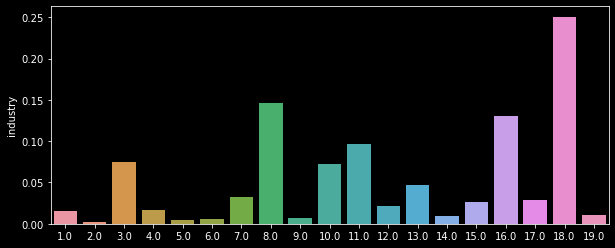

In [385]:
sns.barplot(x=df_income['industry'].value_counts().index,
            y=df_income['industry'].value_counts(normalize = True))

Highest sectopr is **Jasa Kemasyarakatan, pem dan perorangan**, followed by **Industri pengolahan** and **Jasa pendidikan**.

##### Count Plot for moved

<AxesSubplot:ylabel='moved'>

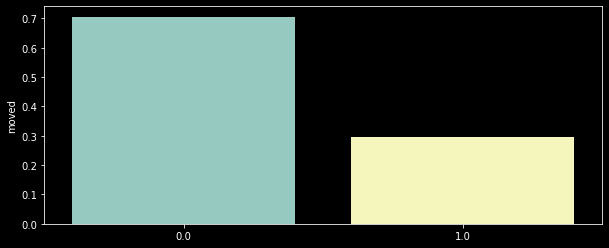

In [386]:
sns.barplot(x=df_income['moved'].value_counts().index,
            y=df_income['moved'].value_counts(normalize = True))

There are more observation that did not move from their place of birth compared to those who moved with a ratio of 2 to 1.

##### _df_cap_

In [387]:
df_cap = df_treat.copy()

In [388]:
missing_value(df_cap)

,Total,Percent
nett_income,628776,56.420550
work_day,594543,53.348797
work_hour,594543,53.348797
industry,590171,52.956494
employ_status,590171,52.956494
commute_ori,583586,52.365617
commute_vehicle,583586,52.365617
is_working,221507,19.875992
log_exp_cap,0,0.000000
age,0,0.000000


As seen in the table above, even after we drop the null values from nett income field, and filter to only rows of data where nett income is greater than 0, for the following fields, there's still null values:
1. _work_hour_ or total working hours;
2. _work_day_ or total working day;
3. _employ_status_ or the role in the job;
4. _commute_vehicle_ and _comute_ori_ or the type vehicle used for commuting;
5. _industry_ or job sector

These null values will be dropped(?)

In [389]:
#drop_missingval(df_cap,['work_hour','work_day','commute_vehicle','commute_ori','employ_status','industry'])

### Merge with Modul dataset

#### Using Nett Income Field

In [390]:
df_inc_merge_43 = pd.merge(left=df_income, right=sus12_m43, how='left', left_on='URUT', right_on='URUT')
df_inc_merge_43

,URUT,age,marital_status,commute_ori,work_day,work_hour,nett_income,industry,employ_status,EXP_CAP_x,WEIND_x,bps_2009,yrs_school,gender,urban,moved,is_working,commute_vehicle,log_exp_cap,B1R1,B1R2,B1R5,B1R8,B2R1,FOOD,NFOOD,EXPEND,KAPITA,KALORI,WERT,WEIND_y,EXP_CAP_y,KABU
0,110112500101603,60,2,3.0,5.0,40.0,3900000.0,18.0,4.0,1.305774e+06,20.006414,1101,16,1.0,1.0,0.0,1.0,2.0,14.082306,11,1,1,3,4,2.901429e+06,2.321667e+06,5.223095e+06,1.305774e+06,2593.590357,20.006414,80.025658,1.305774e+06,1101
1,110112500101603,46,2,3.0,6.0,42.0,2900000.0,18.0,4.0,1.305774e+06,20.006414,1101,16,0.0,1.0,0.0,1.0,2.0,14.082306,11,1,1,3,4,2.901429e+06,2.321667e+06,5.223095e+06,1.305774e+06,2593.590357,20.006414,80.025658,1.305774e+06,1101
2,110112500101604,42,2,3.0,7.0,40.0,3000000.0,18.0,4.0,4.017619e+05,42.398369,1101,12,1.0,1.0,0.0,1.0,2.0,12.903615,11,1,1,4,6,1.394571e+06,1.016000e+06,2.410571e+06,4.017619e+05,1430.819048,42.398369,254.390213,4.017619e+05,1101
3,110112500101605,34,2,3.0,5.0,40.0,1800000.0,18.0,4.0,7.000714e+05,43.420265,1101,16,1.0,1.0,0.0,1.0,2.0,13.458938,11,1,1,5,4,1.588286e+06,1.212000e+06,2.800286e+06,7.000714e+05,1482.632143,43.420265,173.681061,7.000714e+05,1101
4,110112500101605,31,2,3.0,5.0,40.0,1200000.0,18.0,4.0,7.000714e+05,43.420265,1101,12,0.0,1.0,0.0,1.0,2.0,13.458938,11,1,1,5,4,1.588286e+06,1.212000e+06,2.800286e+06,7.000714e+05,1482.632143,43.420265,173.681061,7.000714e+05,1101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167437,947122001103806,23,1,1.0,5.0,40.0,1000000.0,18.0,4.0,1.648210e+06,438.129364,9471,12,0.0,0.0,0.0,1.0,0.0,14.315200,94,71,2,6,5,3.085714e+06,5.155333e+06,8.241048e+06,1.648210e+06,1381.880000,438.129364,2190.646820,1.648210e+06,9471
167438,947122001103807,46,2,1.0,5.0,40.0,4800000.0,18.0,4.0,1.959000e+06,321.015991,9471,18,1.0,0.0,1.0,1.0,0.0,14.487945,94,71,2,7,5,4.860000e+06,4.935000e+06,9.795000e+06,1.959000e+06,1970.742286,321.015991,1605.079956,1.959000e+06,9471
167439,947122001103807,42,2,1.0,5.0,40.0,2500000.0,18.0,4.0,1.959000e+06,321.015991,9471,16,0.0,0.0,1.0,1.0,0.0,14.487945,94,71,2,7,5,4.860000e+06,4.935000e+06,9.795000e+06,1.959000e+06,1970.742286,321.015991,1605.079956,1.959000e+06,9471
167440,947122001103810,37,2,1.0,6.0,36.0,2000000.0,18.0,4.0,1.348310e+06,6.000000,9471,16,1.0,0.0,0.0,1.0,0.0,14.114362,94,71,2,10,6,3.462857e+06,4.627000e+06,8.089857e+06,1.348310e+06,1573.511905,6.000000,36.000000,1.348310e+06,9471


#### Using Monthly Expenditure per Capita

In [391]:
df_cap_merge_43 = pd.merge(left=df_cap, right=sus12_m43, how='left', left_on='URUT', right_on='URUT')
df_cap_merge_43

,URUT,age,marital_status,commute_ori,work_day,work_hour,nett_income,industry,employ_status,EXP_CAP_x,WEIND_x,bps_2009,yrs_school,gender,urban,moved,is_working,commute_vehicle,log_exp_cap,B1R1,B1R2,B1R5,B1R8,B2R1,FOOD,NFOOD,EXPEND,KAPITA,KALORI,WERT,WEIND_y,EXP_CAP_y,KABU
0,110112500101601,41,2,3.0,7.0,35.0,0.0,8.0,2.0,3.434643e+05,45.876255,1101,12,1.0,1.0,0.0,1.0,2.0,12.746838,11,1,1,1,4,8.168571e+05,5.570000e+05,1.373857e+06,3.434643e+05,1277.633929,45.876255,183.505020,3.434643e+05,1101
1,110112500101601,30,2,NaN,NaN,NaN,NaN,NaN,NaN,3.434643e+05,45.876255,1101,12,0.0,1.0,0.0,0.0,NaN,12.746838,11,1,1,1,4,8.168571e+05,5.570000e+05,1.373857e+06,3.434643e+05,1277.633929,45.876255,183.505020,3.434643e+05,1101
2,110112500101601,5,1,NaN,NaN,NaN,NaN,NaN,NaN,3.434643e+05,45.876255,1101,3,0.0,1.0,0.0,NaN,NaN,12.746838,11,1,1,1,4,8.168571e+05,5.570000e+05,1.373857e+06,3.434643e+05,1277.633929,45.876255,183.505020,3.434643e+05,1101
3,110112500101601,0,1,NaN,NaN,NaN,NaN,NaN,NaN,3.434643e+05,45.876255,1101,0,1.0,1.0,1.0,NaN,NaN,12.746838,11,1,1,1,4,8.168571e+05,5.570000e+05,1.373857e+06,3.434643e+05,1277.633929,45.876255,183.505020,3.434643e+05,1101
4,110112500101602,35,2,3.0,7.0,56.0,0.0,11.0,3.0,5.703095e+05,55.252186,1101,9,1.0,1.0,0.0,1.0,2.0,13.253935,11,1,1,2,4,1.334571e+06,9.466667e+05,2.281238e+06,5.703095e+05,1793.693929,55.252186,221.008743,5.703095e+05,1101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114440,947122001103810,37,2,6.0,5.0,10.0,500000.0,16.0,4.0,1.348310e+06,6.000000,9471,12,0.0,0.0,0.0,1.0,1.0,14.114362,94,71,2,10,6,3.462857e+06,4.627000e+06,8.089857e+06,1.348310e+06,1573.511905,6.000000,36.000000,1.348310e+06,9471
1114441,947122001103810,10,1,NaN,NaN,NaN,NaN,NaN,NaN,1.348310e+06,6.000000,9471,3,1.0,0.0,0.0,0.0,NaN,14.114362,94,71,2,10,6,3.462857e+06,4.627000e+06,8.089857e+06,1.348310e+06,1573.511905,6.000000,36.000000,1.348310e+06,9471
1114442,947122001103810,9,1,NaN,NaN,NaN,NaN,NaN,NaN,1.348310e+06,6.000000,9471,3,0.0,0.0,0.0,NaN,NaN,14.114362,94,71,2,10,6,3.462857e+06,4.627000e+06,8.089857e+06,1.348310e+06,1573.511905,6.000000,36.000000,1.348310e+06,9471
1114443,947122001103810,46,1,NaN,NaN,NaN,NaN,NaN,NaN,1.348310e+06,6.000000,9471,9,0.0,0.0,0.0,0.0,NaN,14.114362,94,71,2,10,6,3.462857e+06,4.627000e+06,8.089857e+06,1.348310e+06,1573.511905,6.000000,36.000000,1.348310e+06,9471


# Exploratory Data Analysis

**Analysis Objective:**
Identify what variables has an impact to income.

**Hypothesis:**
The hypothesis is that the following variables might have an impact to income on an individual level.
- _Level of education._ As previously mentioned, higher level of education might increase the likelihood of people to get a higher income level.
- _Region they reside in._ Different regions might have different level of minimum wage, which might have an impact of level of income.

## Using Nett Income Data

### Creating an Aggregated View per Kabupaten/Kota

In [398]:
# Creating Lambda Function for Weighted Average and Weighted Sum
wt_mean = lambda x: np.average(x, weights=df_income.loc[x.index, "WEIND"])
wt_sum = lambda x: np.sum(x, weights=df_income.loc[x.index, "WEIND"])

wt_mean_annex = lambda x: np.average(x, weights=df_raw.loc[x.index, "WEIND"])

# Creating Collapsed Dataframe
df_group = df_income.groupby("bps_2009").agg(EXP_CAP=("EXP_CAP",wt_mean),
                                             urban=("urban",wt_mean),
                                             gender=("gender",wt_mean),
                                             marital_status=("marital_status",wt_mean),
                                             industry=("industry",wt_mean),
                                             commute_vehicle=("commute_vehicle",wt_mean),
                                             yrs_school=("yrs_school",wt_mean),
                                             work_hour=("work_hour",wt_mean),
                                             work_day=("work_day",wt_mean),
                                             nett_income=("nett_income",wt_mean),
                                             WEIND=("WEIND","sum"))

# Mean Age (Processed Differently)
df_grouped_annex = df_income.groupby("bps_2009").agg(age=("age",wt_mean_annex))

# Creating Log Expenditure per Capita
df_group=df_group.assign(log_exp_cap=np.log(df_group['EXP_CAP']))

# Merging Both
df_grouped=pd.concat([df_group,df_grouped_annex],axis=1)
df_grouped

,EXP_CAP,urban,gender,marital_status,industry,commute_vehicle,yrs_school,work_hour,work_day,nett_income,WEIND,log_exp_cap,age
bps_2009,,,,,,,,,,,,,
1101,8.181917e+05,0.408004,0.662506,1.857029,15.638447,1.582995,12.366387,39.301753,5.654547,1.608693e+06,8.227501e+03,13.614852,35.360639
1102,5.958566e+05,0.265525,0.673312,1.843232,9.128524,1.633882,8.978354,37.954776,5.569927,1.397020e+06,1.627065e+04,13.297755,32.557483
1103,6.385679e+05,0.223280,0.711088,1.681549,12.982014,1.335205,10.760693,39.815653,5.580730,1.453273e+06,2.387610e+04,13.366983,34.716317
1104,5.508644e+05,0.220122,0.666496,1.970437,15.285116,1.302628,12.226784,32.185180,5.492067,1.677144e+06,1.131117e+04,13.219244,35.997709
1105,5.927327e+05,0.158691,0.733621,1.851908,8.669040,1.093862,8.538339,37.370073,5.719055,1.213362e+06,5.436180e+04,13.292499,35.751152
1106,9.604278e+05,0.423984,0.633656,1.895251,14.936455,1.398274,12.288749,35.396212,5.448956,1.939019e+06,1.935032e+04,13.775134,35.887835
1107,7.878947e+05,0.361439,0.717798,1.821894,11.245972,1.549226,10.483980,40.171388,5.789849,1.635866e+06,3.104696e+04,13.577120,34.849693
1108,9.034550e+05,0.341425,0.731895,1.790013,12.605196,1.534200,11.399330,41.430681,5.892763,1.863877e+06,6.050276e+04,13.713982,34.761394
1109,7.507020e+05,0.244954,0.669537,1.751245,12.798040,1.338279,11.387830,41.546222,6.000920,1.683396e+06,4.273255e+04,13.528764,35.075435


In [399]:
df_grouped.describe()

,EXP_CAP,urban,gender,marital_status,industry,commute_vehicle,yrs_school,work_hour,work_day,nett_income,WEIND,log_exp_cap,age
count,4.960000e+02,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,4.960000e+02,4.960000e+02,496.000000,496.000000
mean,7.992618e+05,0.463656,0.682858,1.816908,12.563036,1.358566,10.680024,42.218253,5.775563,1.715534e+06,8.602480e+04,13.546425,34.699459
std,2.519798e+05,0.302023,0.075863,0.076654,2.169798,0.331769,1.271826,4.093535,0.223530,4.873077e+05,1.457280e+05,0.295919,1.668950
min,3.662768e+05,0.000000,0.439128,1.612083,5.946573,0.000000,7.036610,21.464948,4.359891,8.725784e+05,1.946361e+02,12.811145,28.201275
25%,6.211994e+05,0.244858,0.633585,1.768342,11.174846,1.176846,9.742638,39.360704,5.647369,1.367264e+06,1.564110e+04,13.339403,33.610138
50%,7.474216e+05,0.407430,0.678597,1.812589,12.782874,1.404169,10.761144,42.491324,5.816304,1.621188e+06,3.620517e+04,13.524385,34.692017
75%,9.393976e+05,0.669986,0.728631,1.859727,14.046873,1.586462,11.640053,45.288093,5.921430,1.982349e+06,8.440081e+04,13.752994,35.787698
max,2.023430e+06,1.000000,1.000000,2.423361,18.000000,2.034315,15.000000,51.984243,6.342743,4.572349e+06,1.068640e+06,14.520305,40.716578


### Nett Income vs Years of School

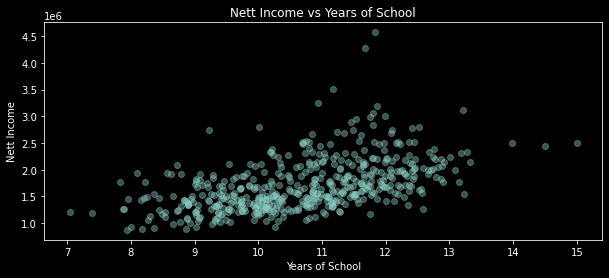

In [400]:
x_var = df_grouped["yrs_school"]
y_var = df_grouped["nett_income"]

# Plot
plt.scatter(x_var, y_var, alpha=0.4)
plt.title('Nett Income vs Years of School')
plt.xlabel('Years of School')
plt.ylabel('Nett Income')
plt.rcParams['figure.figsize'] = [10,10]
plt.show()

### Log Expenditure per Capita vs Years of School

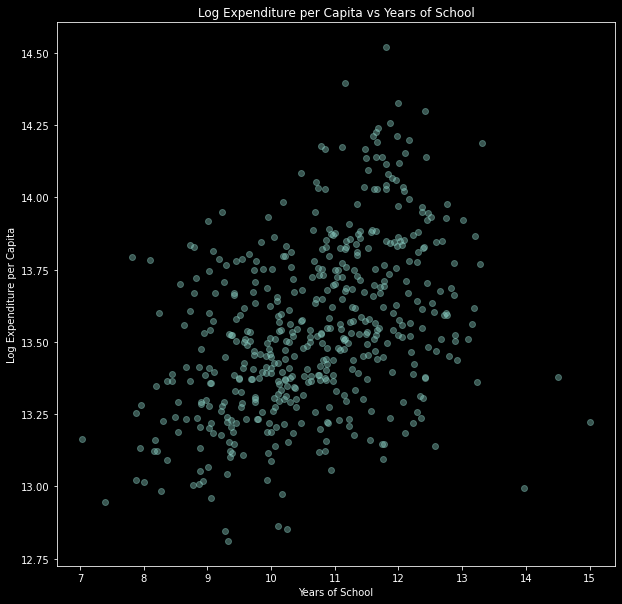

In [401]:
x_var = df_grouped["yrs_school"]
y_var = df_grouped["log_exp_cap"]

# Plot
plt.scatter(x_var, y_var, alpha=0.4)
plt.title('Log Expenditure per Capita vs Years of School')
plt.xlabel('Years of School')
plt.ylabel('Log Expenditure per Capita')
plt.rcParams['figure.figsize'] = [10,10]
plt.show()

### Nett Income vs Work Hours

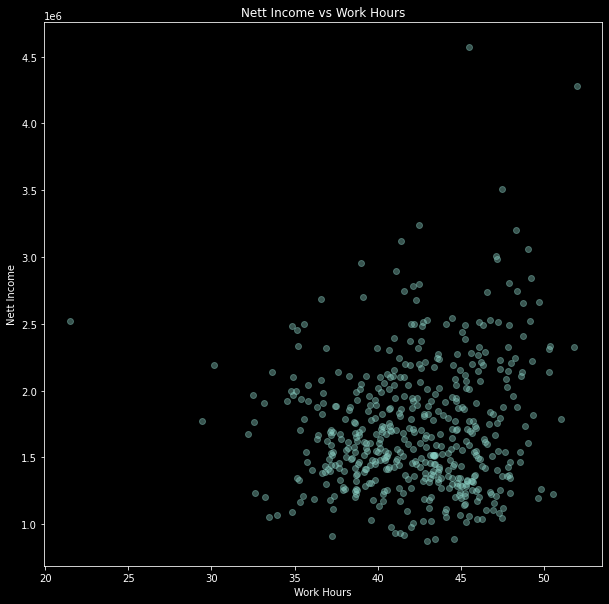

In [402]:
x_var = df_grouped["work_hour"]
y_var = df_grouped["nett_income"]

# Plot
plt.scatter(x_var, y_var, alpha=0.4)
plt.title('Nett Income vs Work Hours')
plt.xlabel('Work Hours')
plt.ylabel('Nett Income')
plt.rcParams['figure.figsize'] = [10,10]
plt.show()

### Log Expenditure per Capita vs Work Hours

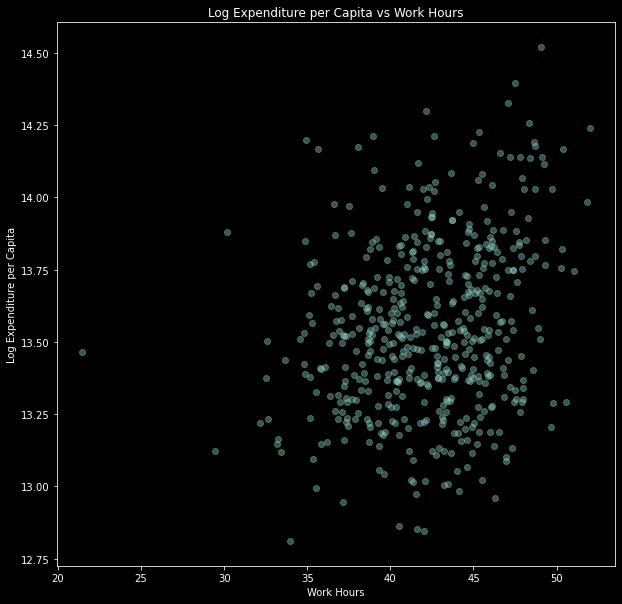

In [403]:
x_var = df_grouped["work_hour"]
y_var = df_grouped["log_exp_cap"]

# Plot
plt.scatter(x_var, y_var, alpha=0.4)
plt.title('Log Expenditure per Capita vs Work Hours')
plt.xlabel('Work Hours')
plt.ylabel('Log Expenditure per Capita')
plt.rcParams['figure.figsize'] = [10,10]
plt.show()

### Nett Income vs Work Day

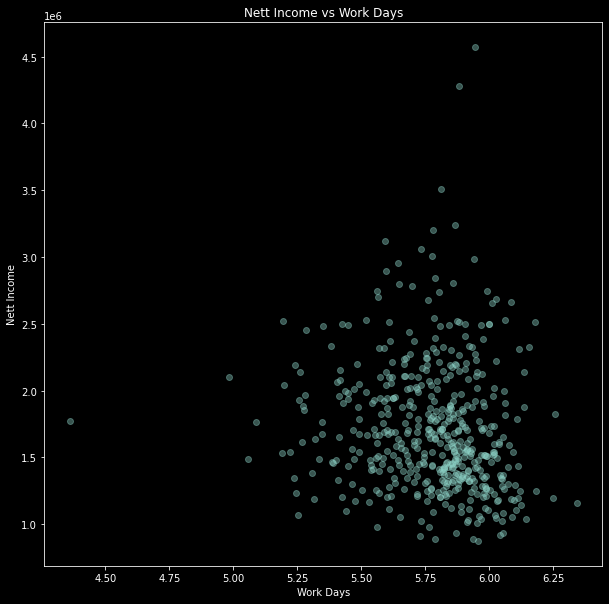

In [404]:
x_var = df_grouped["work_day"]
y_var = df_grouped["nett_income"]

# Plot
plt.scatter(x_var, y_var, alpha=0.4)
plt.title('Nett Income vs Work Days')
plt.xlabel('Work Days')
plt.ylabel('Nett Income')
plt.rcParams['figure.figsize'] = [10,10]
plt.show()

### Log Expenditure per Capita vs Work Day

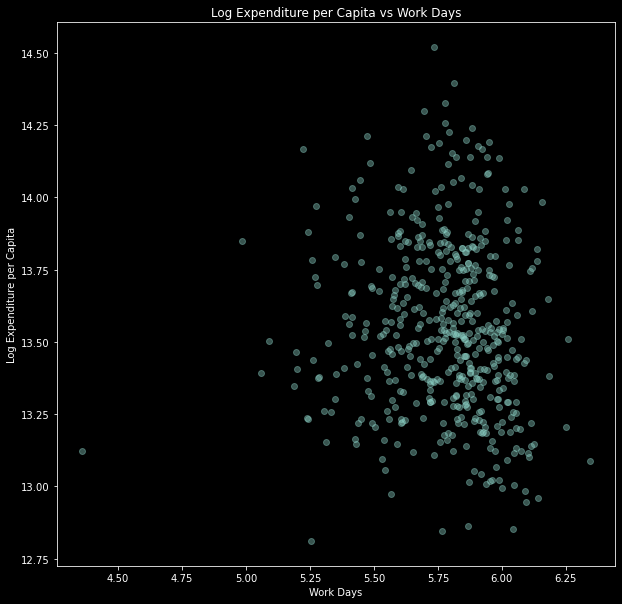

In [405]:
x_var = df_grouped["work_day"]
y_var = df_grouped["log_exp_cap"]

# Plot
plt.scatter(x_var, y_var, alpha=0.4)
plt.title('Log Expenditure per Capita vs Work Days')
plt.xlabel('Work Days')
plt.ylabel('Log Expenditure per Capita')
plt.rcParams['figure.figsize'] = [10,10]
plt.show()

## Regression (Comparing Collapsed Data with Original Data)

In this case, we will use a panel data, both on individual level and on a district level. This is to show impact to how we can interpret the data based on the level of data we use. 

Specifically, we will compare three (3) type of regressions with the same dependent variables but with different level of observation and using a different weightage:
1. Using Individual Level Data, Weighted
2. Using District Level Data, Weighted
3. Using District Level Data, Unweighted


In [406]:
df_income.describe()

,URUT,age,marital_status,commute_ori,work_day,work_hour,nett_income,industry,employ_status,EXP_CAP,WEIND,bps_2009,yrs_school,gender,urban,moved,is_working,commute_vehicle,log_exp_cap
count,1.674420e+05,167442.000000,167442.000000,167442.000000,167442.000000,167442.000000,1.674420e+05,167442.000000,167442.0,1.674420e+05,167442.000000,167442.000000,167442.000000,167442.000000,167442.000000,167442.000000,167442.0,167442.000000,167442.000000
mean,4.028122e+14,35.778377,1.814664,3.195972,5.813506,43.696181,1.813547e+06,12.304589,4.0,8.873795e+05,254.824347,4027.965176,10.670764,0.657935,0.636184,0.294269,1.0,1.456439,13.416329
std,2.284873e+14,11.474623,0.578372,2.136537,1.133662,15.627863,2.012223e+06,5.083948,0.0,1.045330e+06,238.212264,2284.870852,4.048543,0.474403,0.481098,0.455715,0.0,1.009835,0.694350
min,1.101125e+14,10.000000,1.000000,1.000000,0.000000,0.000000,2.000000e+04,1.000000,4.0,8.663280e+04,1.000000,1101.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,11.369434
25%,1.871115e+14,27.000000,1.000000,1.000000,5.000000,36.000000,7.680000e+05,8.000000,4.0,4.026969e+05,89.413795,1871.000000,6.000000,0.000000,0.000000,0.000000,1.0,0.000000,12.905939
50%,3.374115e+14,35.000000,2.000000,3.000000,6.000000,45.000000,1.325000e+06,13.000000,4.0,6.347846e+05,169.757721,3374.000000,12.000000,1.000000,1.000000,0.000000,1.0,2.000000,13.361041
75%,6.202220e+14,44.000000,2.000000,3.000000,6.000000,50.000000,2.371000e+06,18.000000,4.0,1.041006e+06,348.536263,6202.000000,12.000000,1.000000,1.000000,1.000000,1.0,2.000000,13.855699
max,9.471220e+14,98.000000,4.000000,10.000000,7.000000,98.000000,1.000000e+08,19.000000,4.0,7.529981e+07,3151.935791,9471.000000,18.000000,1.000000,1.000000,1.000000,1.0,4.000000,18.136988


In [407]:
df_grouped.describe()

,EXP_CAP,urban,gender,marital_status,industry,commute_vehicle,yrs_school,work_hour,work_day,nett_income,WEIND,log_exp_cap,age
count,4.960000e+02,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,4.960000e+02,4.960000e+02,496.000000,496.000000
mean,7.992618e+05,0.463656,0.682858,1.816908,12.563036,1.358566,10.680024,42.218253,5.775563,1.715534e+06,8.602480e+04,13.546425,34.699459
std,2.519798e+05,0.302023,0.075863,0.076654,2.169798,0.331769,1.271826,4.093535,0.223530,4.873077e+05,1.457280e+05,0.295919,1.668950
min,3.662768e+05,0.000000,0.439128,1.612083,5.946573,0.000000,7.036610,21.464948,4.359891,8.725784e+05,1.946361e+02,12.811145,28.201275
25%,6.211994e+05,0.244858,0.633585,1.768342,11.174846,1.176846,9.742638,39.360704,5.647369,1.367264e+06,1.564110e+04,13.339403,33.610138
50%,7.474216e+05,0.407430,0.678597,1.812589,12.782874,1.404169,10.761144,42.491324,5.816304,1.621188e+06,3.620517e+04,13.524385,34.692017
75%,9.393976e+05,0.669986,0.728631,1.859727,14.046873,1.586462,11.640053,45.288093,5.921430,1.982349e+06,8.440081e+04,13.752994,35.787698
max,2.023430e+06,1.000000,1.000000,2.423361,18.000000,2.034315,15.000000,51.984243,6.342743,4.572349e+06,1.068640e+06,14.520305,40.716578


### Using Nett Income

**Independent Variable**
1. _yrs_school_
2. _work_hours_
3. _age_
4. _urban_
5. _gender_


**Dependent Variable**: _nett_income_

#### Using Individual Level Data (Weighted)

In [408]:
# Using Individual Level Data (Weighted)

x = df_income[['yrs_school','work_hour','work_day','age','urban','gender']]
y = df_income['nett_income']
w = df_income['WEIND']
x = sm.add_constant(x)

est_1 = sm.WLS(y,x,weights=w)
reg_1 = est_1.fit()

wls_reg_1 = pd.concat([reg_1.params,reg_1.tvalues],axis=1)
wls_reg_1.columns=['Coefficient','t-values']
wls_reg_1

,Coefficient,t-values
const,-1.996979e+06,-55.574869
yrs_school,1.977233e+05,156.916863
work_hour,1.326907e+04,35.147808
work_day,-1.466179e+05,-27.499309
age,4.212119e+04,98.849705
urban,2.685801e+05,25.206327
gender,4.599214e+05,45.269504


##### Analysis

Regression output on individual level (top) compared to district level (bottom) has a significant different in regression coefficient _t-values_, especially because the variation on individual lebel is gone by aggregation on district level.

Specific example,the coefficient for _age_ variable changes in direction, where the coefficient between individual level is 98.85 and district level is -7.35. Other than the significant change in variation (variation in age in individual level is 10-98, while on district level is 28 - 40), this also might be caused by the use of average for the aggregated data from all data (df_raw) and not only from the subset of data (df_grouped). Hence, in this case, the numbers cannot be compared.

#### Using District Level Data (Weighted)

In [409]:
# Using District Level Data (Weighted)

x = df_grouped[['yrs_school','work_hour','work_day','age','urban','gender']]
y = df_grouped['nett_income']
w = df_grouped['WEIND']
x = sm.add_constant(x)

est_2 = sm.WLS(y,x,weights=w)
reg_2 = est_2.fit()

wls_reg_2 = pd.concat([reg_2.params,reg_2.tvalues],axis=1)
wls_reg_2.columns=['Coefficient','t-values']
wls_reg_2

,Coefficient,t-values
const,-2.514330e+05,-0.350470
yrs_school,3.348130e+05,21.519369
work_hour,4.271284e+04,5.713046
work_day,-5.330736e+05,-4.426353
age,-7.138116e+04,-7.348571
urban,1.627216e+05,1.987275
gender,3.042599e+06,11.771992


####  Using District Level Data (Unweighted)

In [410]:
# Using District Level Data (Unweighted)

x = df_grouped[['yrs_school','work_hour','work_day','age','urban','gender']]
y = df_grouped['nett_income']
w = df_grouped['WEIND']
x = sm.add_constant(x)

est_3 = sm.OLS(y,x)
reg_3 = est_3.fit()

wls_reg_3 = pd.concat([reg_3.params,reg_3.tvalues],axis=1)
wls_reg_3.columns=['Coefficient','t-values']
wls_reg_3


,Coefficient,t-values
const,-9.252845e+05,-1.573810
yrs_school,2.466713e+05,18.823869
work_hour,3.370440e+04,5.517821
work_day,-4.263230e+05,-4.797907
age,-3.426802e+04,-3.745550
urban,1.828188e+05,2.562324
gender,3.148520e+06,14.777943


##### Analysis

We also see the output coefficient when we use **weighted** regression compared to simple linear regression (OLS) is different, even though it has the same direction. Mathematically,  weighting in regression makes certain observations have a higher/lower weightage compared to others, which results in the difference in output.

This is important for us to understand, especially with the context where district level data has been pre-weighted, which was mandatory, to ensure our aggregated data is representative. Having said that, when we are estimating through regression and finding a causal effect, the reasoning behind weighting might become more complex, and will be explained in this paper by Solon, Haider, and Wooldridge (2013) (Link: https://www.nber.org/system/files/working_papers/w18859/w18859.pdf)

### Using Log Expenditure per Capita

**Independent Variable**
1. _yrs_school_
2. _work_hours_
3. _age_
4. _urban_
5. _gender_


**Dependent Variable**: _log_exp_cap_

#### Using Individual Level Data (Weighted)

In [411]:
# Using Individual Level Data (Weighted)

x = df_income[['yrs_school','work_hour','work_day','age','urban','gender']]
y = df_income['log_exp_cap']
w = df_income['WEIND']
x = sm.add_constant(x)

est_1 = sm.WLS(y,x,weights=w)
reg_1 = est_1.fit()

wls_reg_1 = pd.concat([reg_1.params,reg_1.tvalues],axis=1)
wls_reg_1.columns=['Coefficient','t-values']
wls_reg_1

,Coefficient,t-values
const,12.362385,1074.728417
yrs_school,0.070565,174.942439
work_hour,0.005551,45.929385
work_day,-0.050339,-29.494059
age,0.006351,46.561726
urban,0.272367,79.851382
gender,-0.098063,-30.152280


#### Using District Level Data (Weighted)

In [412]:
# Using District Level Data (Weighted)

x = df_grouped[['yrs_school','work_hour','work_day','age','urban','gender']]
y = df_grouped['log_exp_cap']
w = df_grouped['WEIND']
x = sm.add_constant(x)

est_2 = sm.WLS(y,x,weights=w)
reg_2 = est_2.fit()

wls_reg_2 = pd.concat([reg_2.params,reg_2.tvalues],axis=1)
wls_reg_2.columns=['Coefficient','t-values']
wls_reg_2

,Coefficient,t-values
const,14.710753,34.136199
yrs_school,0.181698,19.441454
work_hour,0.035686,7.946118
work_day,-0.501187,-6.928040
age,-0.067861,-11.630263
urban,0.080896,1.644708
gender,0.912903,5.880052


####  Using District Level Data (Unweighted)

In [413]:
# Using District Level Data (Unweighted)

x = df_grouped[['yrs_school','work_hour','work_day','age','urban','gender']]
y = df_grouped['log_exp_cap']
w = df_grouped['WEIND']
x = sm.add_constant(x)

est_3 = sm.OLS(y,x)
reg_3 = est_3.fit()

wls_reg_3 = pd.concat([reg_3.params,reg_3.tvalues],axis=1)
wls_reg_3.columns=['Coefficient','t-values']
wls_reg_3


,Coefficient,t-values
const,14.890552,37.969100
yrs_school,0.110549,12.647047
work_hour,0.022799,5.595455
work_day,-0.376286,-6.348541
age,-0.054945,-9.003155
urban,0.240541,5.054119
gender,0.704341,4.956022


# Data for Data Studio

## _df_income_

In [213]:
df_inc_merge_43

,URUT,age,marital_status,commute_ori,work_day,work_hour,nett_income,industry,employ_status,EXP_CAP_x,WEIND_x,bps_2009,yrs_school,gender,urban,moved,is_working,commute_vehicle,log_exp_cap,B1R1,B1R2,B1R5,B1R8,B2R1,FOOD,NFOOD,EXPEND,KAPITA,KALORI,WERT,WEIND_y,EXP_CAP_y,KABU
0,110112500101603,60,2,3.0,5.0,40.0,3900000.0,18.0,4.0,1.305774e+06,20.006414,1101,16,1.0,1.0,0.0,1.0,2.0,14.082306,11,1,1,3,4,2.901429e+06,2.321667e+06,5.223095e+06,1.305774e+06,2593.590357,20.006414,80.025658,1.305774e+06,1101
1,110112500101603,46,2,3.0,6.0,42.0,2900000.0,18.0,4.0,1.305774e+06,20.006414,1101,16,0.0,1.0,0.0,1.0,2.0,14.082306,11,1,1,3,4,2.901429e+06,2.321667e+06,5.223095e+06,1.305774e+06,2593.590357,20.006414,80.025658,1.305774e+06,1101
2,110112500101604,42,2,3.0,7.0,40.0,3000000.0,18.0,4.0,4.017619e+05,42.398369,1101,12,1.0,1.0,0.0,1.0,2.0,12.903615,11,1,1,4,6,1.394571e+06,1.016000e+06,2.410571e+06,4.017619e+05,1430.819048,42.398369,254.390213,4.017619e+05,1101
3,110112500101605,34,2,3.0,5.0,40.0,1800000.0,18.0,4.0,7.000714e+05,43.420265,1101,16,1.0,1.0,0.0,1.0,2.0,13.458938,11,1,1,5,4,1.588286e+06,1.212000e+06,2.800286e+06,7.000714e+05,1482.632143,43.420265,173.681061,7.000714e+05,1101
4,110112500101605,31,2,3.0,5.0,40.0,1200000.0,18.0,4.0,7.000714e+05,43.420265,1101,12,0.0,1.0,0.0,1.0,2.0,13.458938,11,1,1,5,4,1.588286e+06,1.212000e+06,2.800286e+06,7.000714e+05,1482.632143,43.420265,173.681061,7.000714e+05,1101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167437,947122001103806,23,1,1.0,5.0,40.0,1000000.0,18.0,4.0,1.648210e+06,438.129364,9471,12,0.0,0.0,0.0,1.0,0.0,14.315200,94,71,2,6,5,3.085714e+06,5.155333e+06,8.241048e+06,1.648210e+06,1381.880000,438.129364,2190.646820,1.648210e+06,9471
167438,947122001103807,46,2,1.0,5.0,40.0,4800000.0,18.0,4.0,1.959000e+06,321.015991,9471,18,1.0,0.0,1.0,1.0,0.0,14.487945,94,71,2,7,5,4.860000e+06,4.935000e+06,9.795000e+06,1.959000e+06,1970.742286,321.015991,1605.079956,1.959000e+06,9471
167439,947122001103807,42,2,1.0,5.0,40.0,2500000.0,18.0,4.0,1.959000e+06,321.015991,9471,16,0.0,0.0,1.0,1.0,0.0,14.487945,94,71,2,7,5,4.860000e+06,4.935000e+06,9.795000e+06,1.959000e+06,1970.742286,321.015991,1605.079956,1.959000e+06,9471
167440,947122001103810,37,2,1.0,6.0,36.0,2000000.0,18.0,4.0,1.348310e+06,6.000000,9471,16,1.0,0.0,0.0,1.0,0.0,14.114362,94,71,2,10,6,3.462857e+06,4.627000e+06,8.089857e+06,1.348310e+06,1573.511905,6.000000,36.000000,1.348310e+06,9471


### Import ref_region

In [207]:
ref_region = pd.read_csv('data/ref_region.csv')
ref_region

,bps_2009,Label,Label_edit,label_final,region_type,provinsi,pulau
0,1101,01. Simeulue,simeulue,simeulue,kabupaten,aceh,sumatera
1,1102,02. Aceh Singkil,aceh singkil,aceh singkil,kabupaten,aceh,sumatera
2,1103,03. Aceh Selatan,aceh selatan,aceh selatan,kabupaten,aceh,sumatera
3,1104,04. Aceh Tenggara,aceh tenggara,aceh tenggara,kabupaten,aceh,sumatera
4,1105,05. Aceh Timur,aceh timur,aceh timur,kabupaten,aceh,sumatera
5,1106,06. Aceh Tengah,aceh tengah,aceh tengah,kabupaten,aceh,sumatera
6,1107,07. Aceh Barat,aceh barat,aceh barat,kabupaten,aceh,sumatera
7,1108,08. Aceh Besar,aceh besar,aceh besar,kabupaten,aceh,sumatera
8,1109,09. Pidie,pidie,pidie,kabupaten,aceh,sumatera
9,1110,10. Bireuen,bireuen,bireuen,kabupaten,aceh,sumatera


### Merge with ref_region

In [214]:
df_merge = pd.merge(left=df_inc_merge_43, right=ref_region, how='left', left_on='bps_2009', right_on='bps_2009')
df_merge

,URUT,age,marital_status,commute_ori,work_day,work_hour,nett_income,industry,employ_status,EXP_CAP_x,WEIND_x,bps_2009,yrs_school,gender,urban,moved,is_working,commute_vehicle,log_exp_cap,B1R1,B1R2,B1R5,B1R8,B2R1,FOOD,NFOOD,EXPEND,KAPITA,KALORI,WERT,WEIND_y,EXP_CAP_y,KABU,Label,Label_edit,label_final,region_type,provinsi,pulau
0,110112500101603,60,2,3.0,5.0,40.0,3900000.0,18.0,4.0,1.305774e+06,20.006414,1101,16,1.0,1.0,0.0,1.0,2.0,14.082306,11,1,1,3,4,2.901429e+06,2.321667e+06,5.223095e+06,1.305774e+06,2593.590357,20.006414,80.025658,1.305774e+06,1101,01. Simeulue,simeulue,simeulue,kabupaten,aceh,sumatera
1,110112500101603,46,2,3.0,6.0,42.0,2900000.0,18.0,4.0,1.305774e+06,20.006414,1101,16,0.0,1.0,0.0,1.0,2.0,14.082306,11,1,1,3,4,2.901429e+06,2.321667e+06,5.223095e+06,1.305774e+06,2593.590357,20.006414,80.025658,1.305774e+06,1101,01. Simeulue,simeulue,simeulue,kabupaten,aceh,sumatera
2,110112500101604,42,2,3.0,7.0,40.0,3000000.0,18.0,4.0,4.017619e+05,42.398369,1101,12,1.0,1.0,0.0,1.0,2.0,12.903615,11,1,1,4,6,1.394571e+06,1.016000e+06,2.410571e+06,4.017619e+05,1430.819048,42.398369,254.390213,4.017619e+05,1101,01. Simeulue,simeulue,simeulue,kabupaten,aceh,sumatera
3,110112500101605,34,2,3.0,5.0,40.0,1800000.0,18.0,4.0,7.000714e+05,43.420265,1101,16,1.0,1.0,0.0,1.0,2.0,13.458938,11,1,1,5,4,1.588286e+06,1.212000e+06,2.800286e+06,7.000714e+05,1482.632143,43.420265,173.681061,7.000714e+05,1101,01. Simeulue,simeulue,simeulue,kabupaten,aceh,sumatera
4,110112500101605,31,2,3.0,5.0,40.0,1200000.0,18.0,4.0,7.000714e+05,43.420265,1101,12,0.0,1.0,0.0,1.0,2.0,13.458938,11,1,1,5,4,1.588286e+06,1.212000e+06,2.800286e+06,7.000714e+05,1482.632143,43.420265,173.681061,7.000714e+05,1101,01. Simeulue,simeulue,simeulue,kabupaten,aceh,sumatera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167437,947122001103806,23,1,1.0,5.0,40.0,1000000.0,18.0,4.0,1.648210e+06,438.129364,9471,12,0.0,0.0,0.0,1.0,0.0,14.315200,94,71,2,6,5,3.085714e+06,5.155333e+06,8.241048e+06,1.648210e+06,1381.880000,438.129364,2190.646820,1.648210e+06,9471,71. Jayapura,jayapura,jayapura,kabupaten,papua,papua
167438,947122001103807,46,2,1.0,5.0,40.0,4800000.0,18.0,4.0,1.959000e+06,321.015991,9471,18,1.0,0.0,1.0,1.0,0.0,14.487945,94,71,2,7,5,4.860000e+06,4.935000e+06,9.795000e+06,1.959000e+06,1970.742286,321.015991,1605.079956,1.959000e+06,9471,71. Jayapura,jayapura,jayapura,kabupaten,papua,papua
167439,947122001103807,42,2,1.0,5.0,40.0,2500000.0,18.0,4.0,1.959000e+06,321.015991,9471,16,0.0,0.0,1.0,1.0,0.0,14.487945,94,71,2,7,5,4.860000e+06,4.935000e+06,9.795000e+06,1.959000e+06,1970.742286,321.015991,1605.079956,1.959000e+06,9471,71. Jayapura,jayapura,jayapura,kabupaten,papua,papua
167440,947122001103810,37,2,1.0,6.0,36.0,2000000.0,18.0,4.0,1.348310e+06,6.000000,9471,16,1.0,0.0,0.0,1.0,0.0,14.114362,94,71,2,10,6,3.462857e+06,4.627000e+06,8.089857e+06,1.348310e+06,1573.511905,6.000000,36.000000,1.348310e+06,9471,71. Jayapura,jayapura,jayapura,kabupaten,papua,papua


### Save to csv

In [217]:
df_merge.to_csv('data/for_dashboard/df_income_test_2.csv')

## _df_cap_

In [215]:
df_cap_merge_43

,URUT,age,marital_status,commute_ori,work_day,work_hour,nett_income,industry,employ_status,EXP_CAP_x,WEIND_x,bps_2009,yrs_school,gender,urban,moved,is_working,commute_vehicle,log_exp_cap,B1R1,B1R2,B1R5,B1R8,B2R1,FOOD,NFOOD,EXPEND,KAPITA,KALORI,WERT,WEIND_y,EXP_CAP_y,KABU
0,110112500101601,41,2,3.0,7.0,35.0,0.0,8.0,2.0,3.434643e+05,45.876255,1101,12,1.0,1.0,0.0,1.0,2.0,12.746838,11,1,1,1,4,8.168571e+05,5.570000e+05,1.373857e+06,3.434643e+05,1277.633929,45.876255,183.505020,3.434643e+05,1101
1,110112500101601,30,2,NaN,NaN,NaN,NaN,NaN,NaN,3.434643e+05,45.876255,1101,12,0.0,1.0,0.0,0.0,NaN,12.746838,11,1,1,1,4,8.168571e+05,5.570000e+05,1.373857e+06,3.434643e+05,1277.633929,45.876255,183.505020,3.434643e+05,1101
2,110112500101601,5,1,NaN,NaN,NaN,NaN,NaN,NaN,3.434643e+05,45.876255,1101,3,0.0,1.0,0.0,NaN,NaN,12.746838,11,1,1,1,4,8.168571e+05,5.570000e+05,1.373857e+06,3.434643e+05,1277.633929,45.876255,183.505020,3.434643e+05,1101
3,110112500101601,0,1,NaN,NaN,NaN,NaN,NaN,NaN,3.434643e+05,45.876255,1101,0,1.0,1.0,1.0,NaN,NaN,12.746838,11,1,1,1,4,8.168571e+05,5.570000e+05,1.373857e+06,3.434643e+05,1277.633929,45.876255,183.505020,3.434643e+05,1101
4,110112500101602,35,2,3.0,7.0,56.0,0.0,11.0,3.0,5.703095e+05,55.252186,1101,9,1.0,1.0,0.0,1.0,2.0,13.253935,11,1,1,2,4,1.334571e+06,9.466667e+05,2.281238e+06,5.703095e+05,1793.693929,55.252186,221.008743,5.703095e+05,1101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114440,947122001103810,37,2,6.0,5.0,10.0,500000.0,16.0,4.0,1.348310e+06,6.000000,9471,12,0.0,0.0,0.0,1.0,1.0,14.114362,94,71,2,10,6,3.462857e+06,4.627000e+06,8.089857e+06,1.348310e+06,1573.511905,6.000000,36.000000,1.348310e+06,9471
1114441,947122001103810,10,1,NaN,NaN,NaN,NaN,NaN,NaN,1.348310e+06,6.000000,9471,3,1.0,0.0,0.0,0.0,NaN,14.114362,94,71,2,10,6,3.462857e+06,4.627000e+06,8.089857e+06,1.348310e+06,1573.511905,6.000000,36.000000,1.348310e+06,9471
1114442,947122001103810,9,1,NaN,NaN,NaN,NaN,NaN,NaN,1.348310e+06,6.000000,9471,3,0.0,0.0,0.0,NaN,NaN,14.114362,94,71,2,10,6,3.462857e+06,4.627000e+06,8.089857e+06,1.348310e+06,1573.511905,6.000000,36.000000,1.348310e+06,9471
1114443,947122001103810,46,1,NaN,NaN,NaN,NaN,NaN,NaN,1.348310e+06,6.000000,9471,9,0.0,0.0,0.0,0.0,NaN,14.114362,94,71,2,10,6,3.462857e+06,4.627000e+06,8.089857e+06,1.348310e+06,1573.511905,6.000000,36.000000,1.348310e+06,9471


### Merge with _ref_region_

In [216]:
df_merge_cap = pd.merge(left=df_cap_merge_43, right=ref_region, how='left', left_on='bps_2009', right_on='bps_2009')
df_merge_cap

,URUT,age,marital_status,commute_ori,work_day,work_hour,nett_income,industry,employ_status,EXP_CAP_x,WEIND_x,bps_2009,yrs_school,gender,urban,moved,is_working,commute_vehicle,log_exp_cap,B1R1,B1R2,B1R5,B1R8,B2R1,FOOD,NFOOD,EXPEND,KAPITA,KALORI,WERT,WEIND_y,EXP_CAP_y,KABU,Label,Label_edit,label_final,region_type,provinsi,pulau
0,110112500101601,41,2,3.0,7.0,35.0,0.0,8.0,2.0,3.434643e+05,45.876255,1101,12,1.0,1.0,0.0,1.0,2.0,12.746838,11,1,1,1,4,8.168571e+05,5.570000e+05,1.373857e+06,3.434643e+05,1277.633929,45.876255,183.505020,3.434643e+05,1101,01. Simeulue,simeulue,simeulue,kabupaten,aceh,sumatera
1,110112500101601,30,2,NaN,NaN,NaN,NaN,NaN,NaN,3.434643e+05,45.876255,1101,12,0.0,1.0,0.0,0.0,NaN,12.746838,11,1,1,1,4,8.168571e+05,5.570000e+05,1.373857e+06,3.434643e+05,1277.633929,45.876255,183.505020,3.434643e+05,1101,01. Simeulue,simeulue,simeulue,kabupaten,aceh,sumatera
2,110112500101601,5,1,NaN,NaN,NaN,NaN,NaN,NaN,3.434643e+05,45.876255,1101,3,0.0,1.0,0.0,NaN,NaN,12.746838,11,1,1,1,4,8.168571e+05,5.570000e+05,1.373857e+06,3.434643e+05,1277.633929,45.876255,183.505020,3.434643e+05,1101,01. Simeulue,simeulue,simeulue,kabupaten,aceh,sumatera
3,110112500101601,0,1,NaN,NaN,NaN,NaN,NaN,NaN,3.434643e+05,45.876255,1101,0,1.0,1.0,1.0,NaN,NaN,12.746838,11,1,1,1,4,8.168571e+05,5.570000e+05,1.373857e+06,3.434643e+05,1277.633929,45.876255,183.505020,3.434643e+05,1101,01. Simeulue,simeulue,simeulue,kabupaten,aceh,sumatera
4,110112500101602,35,2,3.0,7.0,56.0,0.0,11.0,3.0,5.703095e+05,55.252186,1101,9,1.0,1.0,0.0,1.0,2.0,13.253935,11,1,1,2,4,1.334571e+06,9.466667e+05,2.281238e+06,5.703095e+05,1793.693929,55.252186,221.008743,5.703095e+05,1101,01. Simeulue,simeulue,simeulue,kabupaten,aceh,sumatera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114440,947122001103810,37,2,6.0,5.0,10.0,500000.0,16.0,4.0,1.348310e+06,6.000000,9471,12,0.0,0.0,0.0,1.0,1.0,14.114362,94,71,2,10,6,3.462857e+06,4.627000e+06,8.089857e+06,1.348310e+06,1573.511905,6.000000,36.000000,1.348310e+06,9471,71. Jayapura,jayapura,jayapura,kabupaten,papua,papua
1114441,947122001103810,10,1,NaN,NaN,NaN,NaN,NaN,NaN,1.348310e+06,6.000000,9471,3,1.0,0.0,0.0,0.0,NaN,14.114362,94,71,2,10,6,3.462857e+06,4.627000e+06,8.089857e+06,1.348310e+06,1573.511905,6.000000,36.000000,1.348310e+06,9471,71. Jayapura,jayapura,jayapura,kabupaten,papua,papua
1114442,947122001103810,9,1,NaN,NaN,NaN,NaN,NaN,NaN,1.348310e+06,6.000000,9471,3,0.0,0.0,0.0,NaN,NaN,14.114362,94,71,2,10,6,3.462857e+06,4.627000e+06,8.089857e+06,1.348310e+06,1573.511905,6.000000,36.000000,1.348310e+06,9471,71. Jayapura,jayapura,jayapura,kabupaten,papua,papua
1114443,947122001103810,46,1,NaN,NaN,NaN,NaN,NaN,NaN,1.348310e+06,6.000000,9471,9,0.0,0.0,0.0,0.0,NaN,14.114362,94,71,2,10,6,3.462857e+06,4.627000e+06,8.089857e+06,1.348310e+06,1573.511905,6.000000,36.000000,1.348310e+06,9471,71. Jayapura,jayapura,jayapura,kabupaten,papua,papua


### Save to csv

In [218]:
df_merge_cap.to_csv('data/for_dashboard/df_cap_test_2.csv')